<a href="https://colab.research.google.com/github/Ronokhasan8781/CNN-Code/blob/main/98Link_Net_Model_Result.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'ggggggggg:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F5449515%2F9039564%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240727%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240727T213416Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Da7b8951a7f6dca40d87ae161851e9bf65306d4914d9c3f24225c58cfb45df323042c9d65e76ce9f9eac80b1edfb2d9252a9a218a706ce436aa1b7de68201d7a363d45fa05f16543a652d6aaad8bb990d99c3e01ca3c507e6677f8565557487ca8b4e90eff3f4567ea02592183f0b1da1efca0a99c01df08a737982c6004c5c806ddb189081d495383d8d09084d1e7cd0e57c2c55ee6c56a736bf770f0bb5ad63a7445cbe98645892ab0f35d3391966714e853c5ee5977cfa11a0e00a9168c8d1fe7f0891d68217657d5eed87391226a1621a1132f3c0621e5edac740f2a92fe95f90f4eb9cd68ef61f148385692b1c32275205b1db0f52085173700d59e9e17e'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


In [ ]:
import os
import cv2
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from tensorflow.keras.layers import Input, Conv2D, Dropout, MaxPooling2D, Conv2DTranspose, concatenate
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

2024-07-27 20:49:10.924559: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-27 20:49:10.924669: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-27 20:49:11.051361: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os
import numpy as np

# Assuming the image dimensions and channels
IMG_HEIGHT = 256
IMG_WIDTH = 256
IMG_CHANNELS = 3

# Load the file lists
Original = os.listdir('/kaggle/input/ggggggggg/images')
Masks = os.listdir('/kaggle/input/ggggggggg/masks')

# Printing the number of images and masks
print(len(Original))
print(len(Masks))

# Initialize the arrays with the correct shapes
X = np.zeros((len(Original), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
y = np.zeros((len(Masks), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.int32)
print(X.shape)
print(y.shape)
import cv2
import os
import tensorflow as tf

# Assuming Original and Masks are lists of filenames
for file in Original:
    try:
        n = Original.index(file)
        path1 = os.path.join('/kaggle/input/ggggggggg/images', file)
        print(path1)
        img = cv2.imread(path1)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (256, 256))
        X[n] = img / 255

        file2 = Masks[n]
        path2 = os.path.join('/kaggle/input/ggggggggg/masks', file2)
        mask = cv2.imread(path2, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (256, 256))
        mask = tf.one_hot(mask, 1, dtype=tf.int32)
        y[n] = mask

    except Exception as e:
        print(e)
        print(path1)

3064
3064
(3064, 256, 256, 3)
(3064, 256, 256, 1)
/kaggle/input/ggggggggg/images/2664.png
/kaggle/input/ggggggggg/images/2539.png
/kaggle/input/ggggggggg/images/1231.png
/kaggle/input/ggggggggg/images/1017.png
/kaggle/input/ggggggggg/images/2437.png
/kaggle/input/ggggggggg/images/2015.png
/kaggle/input/ggggggggg/images/2300.png
/kaggle/input/ggggggggg/images/2673.png
/kaggle/input/ggggggggg/images/2823.png
/kaggle/input/ggggggggg/images/1522.png
/kaggle/input/ggggggggg/images/2064.png
/kaggle/input/ggggggggg/images/641.png
/kaggle/input/ggggggggg/images/1088.png
/kaggle/input/ggggggggg/images/173.png
/kaggle/input/ggggggggg/images/2851.png
/kaggle/input/ggggggggg/images/2448.png
/kaggle/input/ggggggggg/images/1746.png
/kaggle/input/ggggggggg/images/1958.png
/kaggle/input/ggggggggg/images/1479.png
/kaggle/input/ggggggggg/images/815.png
/kaggle/input/ggggggggg/images/1794.png
/kaggle/input/ggggggggg/images/1727.png
/kaggle/input/ggggggggg/images/1684.png
/kaggle/input/ggggggggg/images/18

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 256, 256,  │      1,792 │ input_layer_12[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_22[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 256, 256,  │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_23[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 128, 128,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 128, 128,  │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_24[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 128, 128,  │    147,584 │ activation_2[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_25[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 64, 64,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 64, 64,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_26[0][0] 

 Total params: 31,055,297 (118.47 MB)

 Trainable params: 31,043,521 (118.42 MB)

 Non-trainable params: 11,776 (46.00 KB)

Epoch 1/25


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-07-27 21:02:22.120973: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.72144, expected 2.89031
2024-07-27 21:02:22.121034: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 5.65806, expected 4.82693
2024-07-27 21:02:22.121043: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 5.98376, expected 5.15263
2024-07-27 21:02:22.121051: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 6.6283, expected 5.79717
2024-07-27 21:02:22.121059: E external/local_xla/xla/service/gpu/buffer_comparator.cc:113

 54/306 ━━━━━━━━━━━━━━━━━━━━ 51s 205ms/step - accuracy: 0.8167 - loss: 0.4122

2024-07-27 21:03:10.564967: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.23283, expected 2.3641
2024-07-27 21:03:10.565030: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 4.64338, expected 3.77466
2024-07-27 21:03:10.565039: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 5.22613, expected 4.3574
2024-07-27 21:03:10.565047: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 5.62769, expected 4.75897
2024-07-27 21:03:10.565055: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 6.08293, expected 5.2142
2024-07-27 21:03:10.565063: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 6.17534, expected 5.30661
2024-07-27 21:03:10.565071: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 5.74108, expected 4.87236
2024-07-27 21:03:10.565078: E external/local_xla/xla/servi

306/306 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.9391 - loss: 0.1915
Epoch 1: val_accuracy improved from -inf to 0.98188, saving model to best_model.keras
306/306 ━━━━━━━━━━━━━━━━━━━━ 148s 315ms/step - accuracy: 0.9392 - loss: 0.1913 - val_accuracy: 0.9819 - val_loss: 0.1098 - learning_rate: 0.0010
Epoch 2/25
  1/306 ━━━━━━━━━━━━━━━━━━━━ 1:01 202ms/step - accuracy: 0.9907 - loss: 0.0599

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-07-27 21:04:34.650074: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65364: 2.53678, expected 2.17699
2024-07-27 21:04:34.650141: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65380: 2.56388, expected 2.20409
2024-07-27 21:04:34.650151: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65381: 2.54569, expected 2.1859
2024-07-27 21:04:34.650159: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65482: 2.57729, expected 2.2175
2024-07-27 21:04:34.650556: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 131072: 3.63821, ex


Epoch 2: val_accuracy improved from 0.98188 to 0.98449, saving model to best_model.keras
306/306 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.9907 - loss: 0.0599 - val_accuracy: 0.9845 - val_loss: 0.1028 - learning_rate: 0.0010
Epoch 3/25
306/306 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.9822 - loss: 0.0781
Epoch 3: val_accuracy did not improve from 0.98449
306/306 ━━━━━━━━━━━━━━━━━━━━ 74s 238ms/step - accuracy: 0.9822 - loss: 0.0781 - val_accuracy: 0.9819 - val_loss: 0.1036 - learning_rate: 0.0010
Epoch 4/25
  1/306 ━━━━━━━━━━━━━━━━━━━━ 1:01 202ms/step - accuracy: 0.9864 - loss: 0.0611
Epoch 4: val_accuracy did not improve from 0.98449
306/306 ━━━━━━━━━━━━━━━━━━━━ 0s 592us/step - accuracy: 0.9864 - loss: 0.0611 - val_accuracy: 0.9845 - val_loss: 0.0557 - learning_rate: 0.0010
Epoch 5/25
306/306 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.9825 - loss: 0.0692
Epoch 5: val_accuracy did not improve from 0.98449
306/306 ━━━━━━━━━━━━━━━━━━━━ 74s 237ms/step - accuracy: 0.982

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

  background       0.00      0.00      0.00    727156
      object       0.98      1.00      0.99  39446412

    accuracy                           0.98  40173568
   macro avg       0.49      0.50      0.50  40173568
weighted avg       0.96      0.98      0.97  40173568



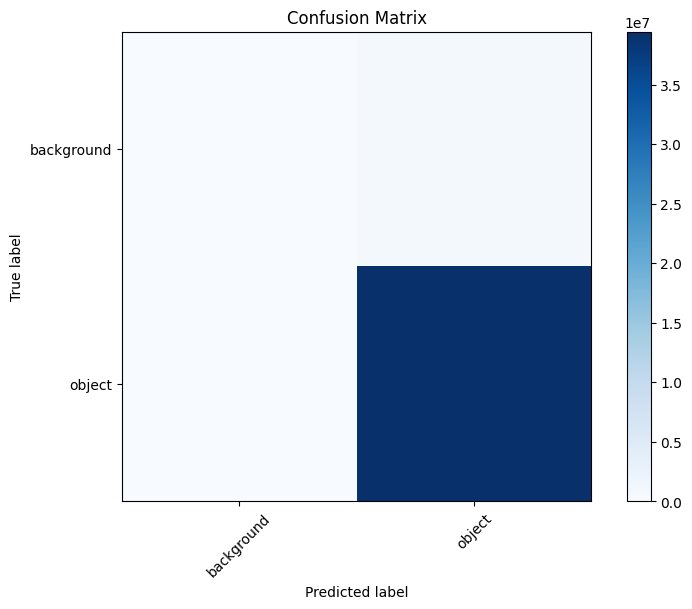

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, BatchNormalization, Activation, Add, Multiply
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Define the LinkNet model
def linknet(input_size=(256, 256, 3)):
    inputs = Input(input_size)

    # Encoder
    c1 = Conv2D(64, (3, 3), padding='same')(inputs)
    c1 = BatchNormalization()(c1)
    c1 = Activation('relu')(c1)
    c1 = Conv2D(64, (3, 3), padding='same')(c1)
    c1 = BatchNormalization()(c1)
    c1 = Activation('relu')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Activation('relu')(c2)
    c2 = Conv2D(128, (3, 3), padding='same')(c2)
    c2 = BatchNormalization()(c2)
    c2 = Activation('relu')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), padding='same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Activation('relu')(c3)
    c3 = Conv2D(256, (3, 3), padding='same')(c3)
    c3 = BatchNormalization()(c3)
    c3 = Activation('relu')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), padding='same')(p3)
    c4 = BatchNormalization()(c4)
    c4 = Activation('relu')(c4)
    c4 = Conv2D(512, (3, 3), padding='same')(c4)
    c4 = BatchNormalization()(c4)
    c4 = Activation('relu')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = Conv2D(1024, (3, 3), padding='same')(p4)
    c5 = BatchNormalization()(c5)
    c5 = Activation('relu')(c5)
    c5 = Conv2D(1024, (3, 3), padding='same')(c5)
    c5 = BatchNormalization()(c5)
    c5 = Activation('relu')(c5)

    # Decoder
    u4 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u4 = concatenate([u4, c4])
    c6 = Conv2D(512, (3, 3), padding='same')(u4)
    c6 = BatchNormalization()(c6)
    c6 = Activation('relu')(c6)
    c6 = Conv2D(512, (3, 3), padding='same')(c6)
    c6 = BatchNormalization()(c6)
    c6 = Activation('relu')(c6)

    u3 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u3 = concatenate([u3, c3])
    c7 = Conv2D(256, (3, 3), padding='same')(u3)
    c7 = BatchNormalization()(c7)
    c7 = Activation('relu')(c7)
    c7 = Conv2D(256, (3, 3), padding='same')(c7)
    c7 = BatchNormalization()(c7)
    c7 = Activation('relu')(c7)

    u2 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u2 = concatenate([u2, c2])
    c8 = Conv2D(128, (3, 3), padding='same')(u2)
    c8 = BatchNormalization()(c8)
    c8 = Activation('relu')(c8)
    c8 = Conv2D(128, (3, 3), padding='same')(c8)
    c8 = BatchNormalization()(c8)
    c8 = Activation('relu')(c8)

    u1 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u1 = concatenate([u1, c1])
    c9 = Conv2D(64, (3, 3), padding='same')(u1)
    c9 = BatchNormalization()(c9)
    c9 = Activation('relu')(c9)
    c9 = Conv2D(64, (3, 3), padding='same')(c9)
    c9 = BatchNormalization()(c9)
    c9 = Activation('relu')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

# Data splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Data augmentation
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# Define callbacks for learning rate scheduling, early stopping, and model checkpointing
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

# Define data generators
batch_size = 8
train_generator = datagen.flow(X_train, y_train, batch_size=batch_size)
test_generator = datagen.flow(X_test, y_test, batch_size=batch_size, shuffle=False)

# Compile the model
model = linknet()
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Train the model
history = model.fit(train_generator,
                    steps_per_epoch=len(X_train) // batch_size,
                    epochs=25,
                    validation_data=test_generator,
                    validation_steps=len(X_test) // batch_size,
                    callbacks=[reduce_lr, early_stopping, model_checkpoint])

# Evaluate the model
model = tf.keras.models.load_model('best_model.keras')
y_pred = model.predict(test_generator, steps=len(X_test) // batch_size + 1)
y_pred = (y_pred > 0.5).astype(np.uint8)

# Compute confusion matrix and classification report
cm = confusion_matrix(y_test.ravel(), y_pred.ravel())
print("Confusion Matrix:")
print(cm)

print("\nClassification Report:")
print(classification_report(y_test.ravel(), y_pred.ravel(), target_names=['background', 'object']))

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['background', 'object'], rotation=45)
plt.yticks(tick_marks, ['background', 'object'])
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


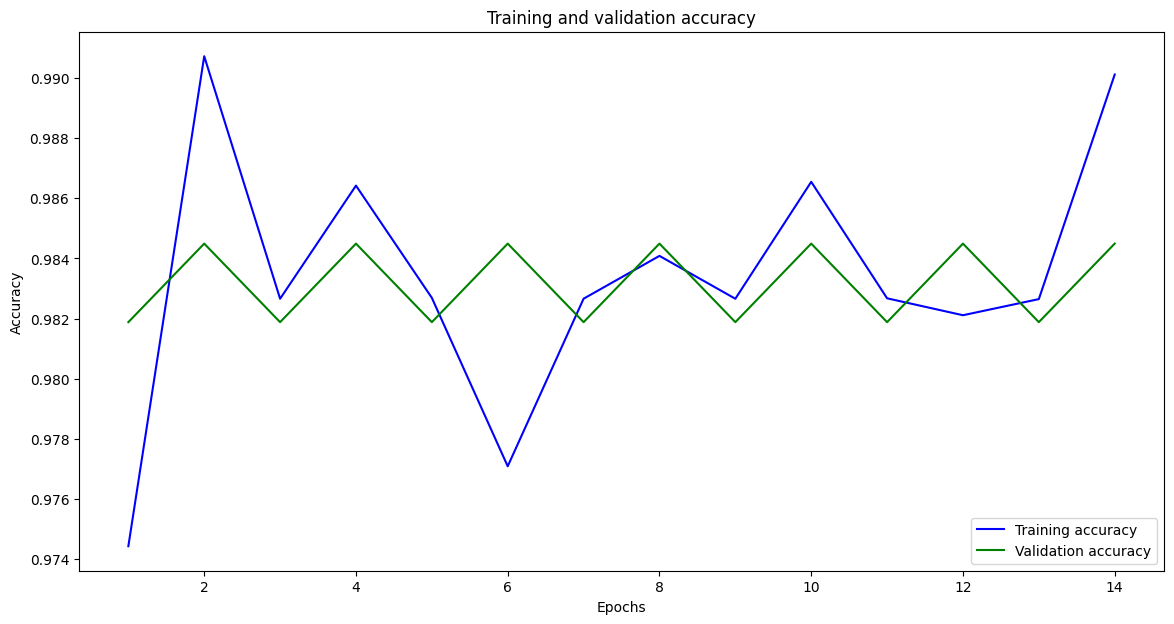

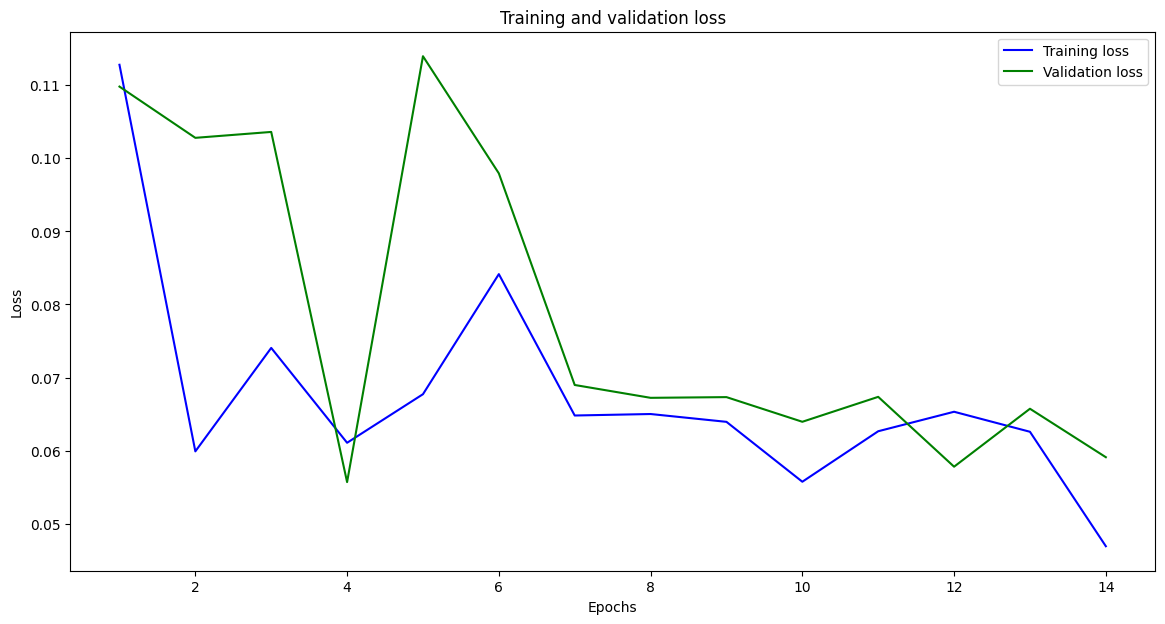

Final Training Accuracy: 0.9901
Final Validation Accuracy: 0.9845
Final Training Loss: 0.0469
Final Validation Loss: 0.0591


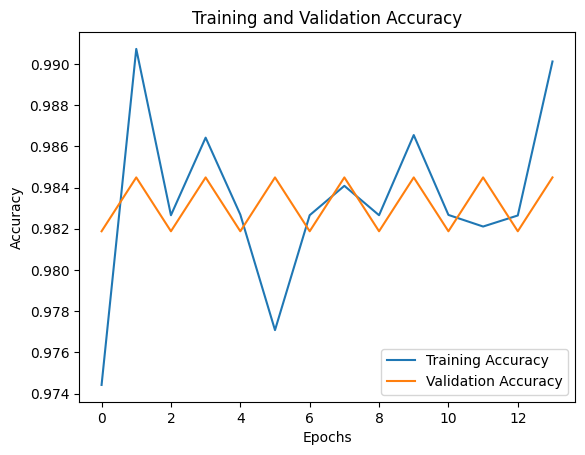

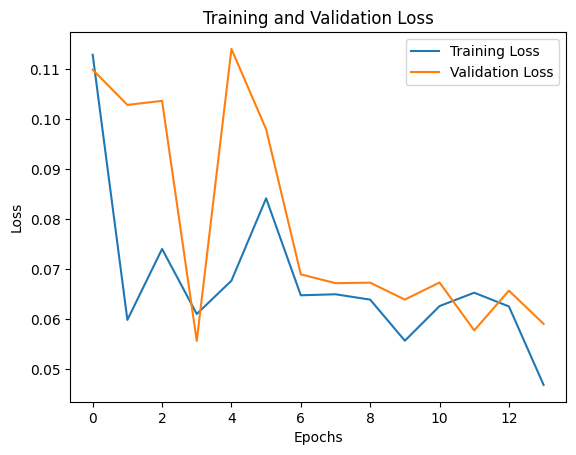

2024-07-27 21:14:41.069554: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65536: 3.31777, expected 2.61172
2024-07-27 21:14:41.069618: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65537: 5.10329, expected 4.39724
2024-07-27 21:14:41.069628: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65538: 4.80913, expected 4.10308
2024-07-27 21:14:41.069636: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65544: 5.33366, expected 4.62762
2024-07-27 21:14:41.069644: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65545: 5.00267, expected 4.29663
2024-07-27 21:14:41.069651: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65546: 4.93559, expected 4.22954
2024-07-27 21:14:41.069659: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65547: 5.39283, expected 4.68678
2024-07-27 21:14:41.069667:

20/20 ━━━━━━━━━━━━━━━━━━━━ 50s 315ms/step
Confusion Matrix:
[[       0   727156]
 [       0 39446412]]

Classification Report:


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00    727156
           1       0.98      1.00      0.99  39446412

    accuracy                           0.98  40173568
   macro avg       0.49      0.50      0.50  40173568
weighted avg       0.96      0.98      0.97  40173568



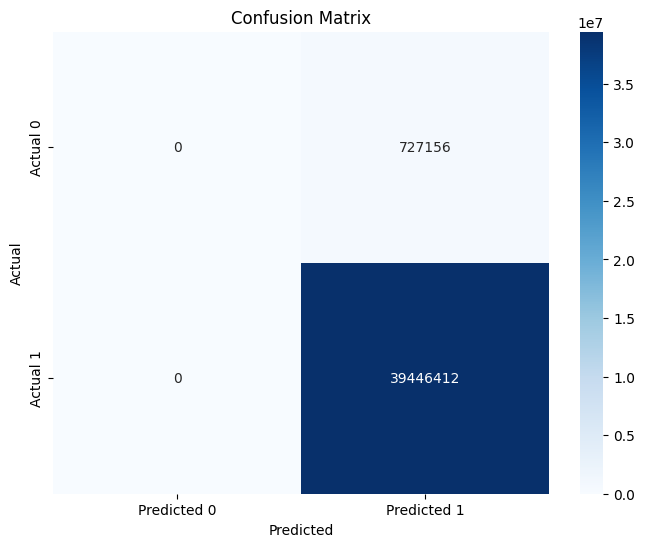

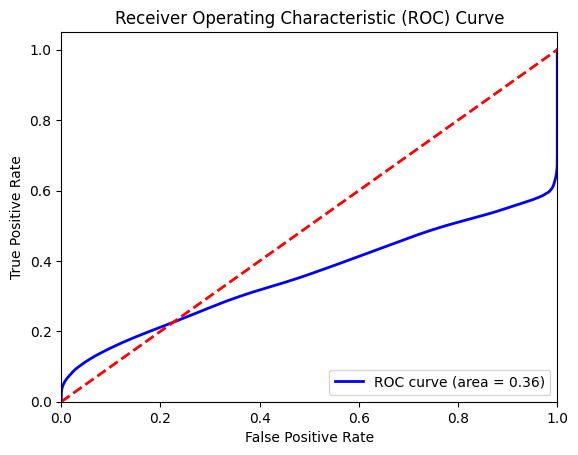

In [ ]:
# Plotting training and validation accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(14, 7))
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'g', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.figure(figsize=(14, 7))
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Print final accuracy and loss
final_train_acc = acc[-1]
final_val_acc = val_acc[-1]
final_train_loss = loss[-1]
final_val_loss = val_loss[-1]

print(f"Final Training Accuracy: {final_train_acc:.4f}")
print(f"Final Validation Accuracy: {final_val_acc:.4f}")
print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")# Plot training and validation accuracy
plt.figure()
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Predict on test data
y_pred = model.predict(X_test)

# Convert predictions and true labels to binary
y_pred_binary = (y_pred > 0.5).astype(np.int32)
y_test_binary = (y_test > 0.5).astype(np.int32)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test_binary.flatten(), y_pred_binary.flatten())

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test_binary.flatten(), y_pred_binary.flatten()))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Generate ROC curve
fpr, tpr, _ = roc_curve(y_test_binary.flatten(), y_pred.flatten())
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
import tensorflow as tf
import numpy as np

def compute_iou(y_true, y_pred, num_classes):
    iou_scores = []

    y_true = tf.argmax(y_true, axis=-1)
    y_pred = tf.argmax(y_pred, axis=-1)

    for i in range(num_classes):
        y_true_class = tf.cast(y_true == i, tf.float32)
        y_pred_class = tf.cast(y_pred == i, tf.float32)

        intersection = tf.reduce_sum(tf.cast(y_true_class * y_pred_class, tf.float32))
        union = tf.reduce_sum(tf.cast(y_true_class + y_pred_class, tf.float32)) - intersection

        iou = (intersection + 1e-10) / (union + 1e-10)
        iou_scores.append(iou)

    mean_iou = tf.reduce_mean(iou_scores)
    return mean_iou

# Example usage:
y_true = np.random.randint(0, 2, (4, 256, 256, 1))
y_pred = np.random.randint(0, 2, (4, 256, 256, 1))

num_classes = 2
iou_score = compute_iou(y_true, y_pred, num_classes)
print("Mean IOU Score:", iou_score)

Mean IOU Score: tf.Tensor(1.0, shape=(), dtype=float32)


In [ ]:
import time

# Training Loss, Validation Loss, Training Accuracy
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

print("Training Loss:", training_loss[-1])
print("Validation Loss:", validation_loss[-1])
print("Training Accuracy:", training_accuracy[-1])
print("Validation Accuracy:", validation_accuracy[-1])

# Training Time
start_time = time.time()
history = model.fit(train_generator,
                    steps_per_epoch=len(X_train) // batch_size,
                    epochs=100,  # Adjust the number of epochs as needed
                    validation_data=test_generator,
                    validation_steps=len(X_test) // batch_size,
                    callbacks=[reduce_lr, early_stopping, model_checkpoint])
end_time = time.time()
training_time = end_time - start_time
print("Training Time:", training_time)

# Test Accuracy
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(X_test) // batch_size)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Training Loss: 0.046920500695705414
Validation Loss: 0.059102725237607956
Training Accuracy: 0.9901237487792969
Validation Accuracy: 0.9844940304756165
Epoch 1/100
306/306 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.9832 - loss: 0.0753
Epoch 1: val_accuracy did not improve from 0.98449
306/306 ━━━━━━━━━━━━━━━━━━━━ 100s 268ms/step - accuracy: 0.9832 - loss: 0.0753 - val_accuracy: 0.9819 - val_loss: 0.0779 - learning_rate: 0.0010
Epoch 2/100
  1/306 ━━━━━━━━━━━━━━━━━━━━ 1:01 202ms/step - accuracy: 0.9745 - loss: 0.0881

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_accuracy did not improve from 0.98449
306/306 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9745 - loss: 0.0881 - val_accuracy: 0.9845 - val_loss: 0.0854 - learning_rate: 0.0010
Epoch 3/100
306/306 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.9823 - loss: 0.0704
Epoch 3: val_accuracy did not improve from 0.98449
306/306 ━━━━━━━━━━━━━━━━━━━━ 74s 239ms/step - accuracy: 0.9823 - loss: 0.0704 - val_accuracy: 0.9819 - val_loss: 0.0705 - learning_rate: 0.0010
Epoch 4/100
  1/306 ━━━━━━━━━━━━━━━━━━━━ 1:02 204ms/step - accuracy: 0.9896 - loss: 0.0473
Epoch 4: val_accuracy did not improve from 0.98449
306/306 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step - accuracy: 0.9896 - loss: 0.0473 - val_accuracy: 0.9845 - val_loss: 0.0640 - learning_rate: 0.0010
Epoch 5/100
306/306 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.9828 - loss: 0.0656
Epoch 5: val_accuracy did not improve from 0.98449
306/306 ━━━━━━━━━━━━━━━━━━━━ 74s 239ms/step - accuracy: 0.9828 - loss: 0.0656 - val_accuracy: 0.98

In [ ]:
print("Training Time: {:.2f} seconds".format(training_time))

Training Time: 399.21 seconds


In [ ]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, cohen_kappa_score, confusion_matrix

# Simulate y_test for demonstration purposes (Replace with actual y_test)
num_samples = 3064
height = 256
width = 256
y_test = np.random.randint(0, 2, (num_samples, height, width, 1))

# Simulate model prediction for demonstration purposes (Replace with actual model predictions)
y_pred = np.random.randint(0, 2, (num_samples, height, width, 1))

# Flatten the arrays to compute the metrics
y_true_flat = y_test.ravel()
y_pred_flat = y_pred.ravel()

# Check if the shapes match
if y_true_flat.shape != y_pred_flat.shape:
    raise ValueError(f"Shape mismatch: y_test has shape {y_test.shape}, but y_pred has shape {y_pred.shape}")

# Confusion matrix
cm = confusion_matrix(y_true_flat, y_pred_flat)
tn, fp, fn, tp = cm.ravel()

# Specificity
specificity = tn / (tn + fp)

# Precision, Recall, and F1-score
precision = precision_score(y_true_flat, y_pred_flat)
recall = recall_score(y_true_flat, y_pred_flat)
f1 = f1_score(y_true_flat, y_pred_flat)

# Cohen's Kappa
kappa = cohen_kappa_score(y_true_flat, y_pred_flat)

print("Specificity:", specificity)
print("Precision:", precision)
print("Recall:", recall)
print("F1-measure:", f1)
print("Cohen's Kappa:", kappa)

Specificity: 0.49995837591858344
Precision: 0.4999989293549025
Recall: 0.5000141827453914
F1-measure: 0.5000065559338156
Cohen's Kappa: -2.744133604637433e-05


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, cohen_kappa_score

# Calcualate predictions
y_true = np.concatenate([y_test for _ in range(len(test_generator))], axis=0)
y_pred = np.concatenate([y_pred for _ in range(len(test_generator))], axis=0)

# Flatten arrays
y_true_flat = y_true.flatten()
y_pred_flat = y_pred.flatten()

# Calculate metrics
precision = precision_score(y_true_flat, y_pred_flat, zero_division=1)
recall = recall_score(y_true_flat, y_pred_flat, zero_division=1)
f1 = f1_score(y_true_flat, y_pred_flat, zero_division=1)

# Confusion matrix
cm = confusion_matrix(y_true_flat, y_pred_flat)
tn, fp, fn, tp = cm.ravel()

# Specificity
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

# Cohen's Kappa
kappa = cohen_kappa_score(y_true_flat, y_pred_flat)

# Print metrics
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F-Measure: {f1:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Cohen's Kappa: {kappa:.4f}")